# LSQT-Jupyter

## 1. Introduction

* `LSQT-Jupyter` is a Jupyter notebook demonstrating some practical apects of the linear-scaling quantum transport methods reviewd in Ref. [1].
* The programming language chosen is `Python 3`.
* We will refer to Ref. [1] frequently for the relevant theoretical backgounds.
* This code is only suitable for leanring the methods. For high performance computing, check the `GPUQT` code I wrote: https://github.com/brucefan1983/gpuqt
* This code only considers square lattice with Anderson disoder as the model system. For more general simulations, again check the `GPUQT` code.
* For fans of `Matlab`, check the `lsqt-matlab` code I wrote: https://github.com/brucefan1983/lsqt-matlab

[1] Zheyong Fan, Jose Hugo Garcia, Aron W Cummings, Jose-Eduardo Barrios, Michel Panhans, Ari Harju, Frank Ortmann, and Stephan Roche, Linear Scaling Quantum Transport Methodologies, submitted to Reviews of Modern Physics. https://arxiv.org/abs/1811.07387

## 2. Unit system (We are working in 2D)
* Basic units:
 * Reduced Planck constant $\hbar$ = 1
 * Elementary charge $e$ = 1
 * Energy unit $\gamma=1$ is hopping integral
 * Length unit $a=1$ is the lattice constant
* Derived units:
 * Time: $\hbar/\gamma$
 * Densit of states (DOS) in 2D: $1/\gamma/a^2$
 * Velocity autocorrelation (VAC): $a^2\gamma^2/\hbar^2$
 * Mean square displacement (MSD): $a^2$
 * Electrical conductivity in 2D: $e^2/\hbar$
 * Electrical conductance: $e^2/\hbar$

## 3. Import the needed Python packages

In [1]:
import numpy as np              # used frequently
import matplotlib as mpl        # do we need this?
import matplotlib.pyplot as plt # used for plotting
from scipy import sparse        # crucial for performance
from scipy import integrate     # do we need this?
from scipy import special       # for Bessel function

## 4. Construct the tight-binding model
1. We consdier the nearest-neighbor tight-bindng model defined on a square lattice with lattice constant $a$ and dimensions $N=N_x\times N_y$.
2. The Hamiltonian can be written as
$$
\hat{H} = \sum_{ij} (-\gamma) c_i^{\dagger} c_j + \sum_i U_i c_i^{\dagger} c_i,
$$
where $-\gamma$ is the hopping integral and $U_i$ are the on-site potentials. The on-site potentials are uniformly distributed in an interval $[-W/2, W/2]$, where $W$ is the Anderson disorder strength. For simplicity, we consider open boundary conditions in the $y$ direction and study the transorpt in the $x$ direction.

### 4.1 Define an indexing scheme
1. The purpose is to map th 2D indices in the lattice into 1D indices
2. The 1D indices will be used for the Hamiltionian, velcoity operator, and various vectors.
3. This only requires a simple function shown below:

In [2]:
def find_index(nx, ny, Ny):
    """
    Get a 1D index from a 2D index
    Args:
        nx (int): x-index of a site
        ny (int): y-index of the same site
    Returns:
        index (int): 1D index for (nx, ny)
    """
    index = nx * Ny + ny
    return index

### 4.2. Define the function for creating the sparse Hamiltonian and velocity operator
1. We consider square lattice with $N_x \times N_y$ lattice sites.
2. Use periodic boundary conditions in the $x$ direction.
3. Use open boundary conditions in the $y$ direction.
4. Assume the transport is in the $x$ direction.
5. All the hoppings integral $\gamma=1$ defines the energy units.
6. The lattices constant $a=1$ defines the length units.
7. Anderson diorder strength is $W$, which means that random on-site potentials are uniformly chosen from $[-W/2, W/2]$. $W$ is in units of $\gamma$.

In [3]:
def find_H(Nx, Ny, W):
    """
    Construct the sparse Hamiltonian and velocity operator
    Args:
        Nx (int): number of lattice points in the x direction
        Ny (int): number of lattice points in the y direction
        W (real): Anderson disorder strength
    Returns:
        H (sparse.csr_matrix): The sparse Hamiltonian
        V (sparse.csr_matrix): The sparse velocity operator
    """
    N = Nx * Ny; # total number of sites
    row_H = np.zeros(N * 4 - Nx * 2) # the row indices for H
    col_H = np.zeros(N * 4 - Nx * 2) # the column indices for H
    Hij = -np.ones(N * 4 - Nx * 2, complex) # nonzero Hamiltonian elements
    row_V = np.zeros(N * 2) # row indices for V
    col_V = np.zeros(N * 2) # column indices for V
    Vij = np.zeros(N * 2, complex) # nonzero velocity matrix elements
    row_U = np.arange(0, N) # row and column indices for U
    Uij = np.random.uniform(-W * 0.5, W * 0.5, N) # on-site potentials
    count_H = 0 # number of nonzero H elements
    count_V = 0 # number of nonzero V elements
    for nx in range(Nx):
        for ny in range(Ny):
            # (0) # get the index of the center site
            index_center = find_index(nx, ny, Ny)
            # (1) consider the left neighbor (periodic boundary)
            index_left = find_index((nx - 1) % Nx, ny, Ny)
            row_H[count_H] = index_center
            col_H[count_H] = index_left
            count_H += 1
            row_V[count_V] = index_center
            col_V[count_V] = index_left
            Vij[count_V] = 1j
            count_V += 1
            # (2) consider the right neighbor (periodic boundary)
            index_right = find_index((nx + 1) % Nx, ny, Ny)
            row_H[count_H] = index_center
            col_H[count_H] = index_right
            count_H += 1
            row_V[count_V] = index_center
            col_V[count_V] = index_right
            Vij[count_V] = -1j
            count_V += 1
            # (3) consider the upper neighbor (open boundary)
            if ny < Ny - 1:
                index_up = find_index(nx, (ny + 1), Ny)
                row_H[count_H] = index_center
                col_H[count_H] = index_up
                count_H += 1
            # (4) consider the down neighbor (open boundary)
            if ny > 0:
                index_down = find_index(nx, (ny - 1), Ny)
                row_H[count_H] = index_center
                col_H[count_H] = index_down
                count_H += 1
    H = sparse.csr_matrix((Hij, (row_H, col_H)), shape = (N, N))
    U = sparse.csr_matrix((Uij, (row_U, row_U)), shape = (N, N))
    H = H + U
    V = sparse.csr_matrix((Vij, (row_V, col_V)), shape = (N, N))
    return (H, V)

### 4.3. Check the `find_H` function and visualize the sparse matrices
1. Try $N_x = N_y = 4$ and print H and V. One can check (with pencil and paper) that the results are correct.
2. Check the pattern of H: each row (or column) only has 4 or 5  nonzero elements.
3. Check the pattern of V: each row (or column) only has 2 nonzero elements.

In [4]:
H, V = find_H(4, 4, 1)
print(H)
print("==========================================")
print(V)

  (0, 0)	(-0.1097309692+0j)
  (0, 1)	(-1+0j)
  (0, 4)	(-1+0j)
  (0, 12)	(-1+0j)
  (1, 0)	(-1+0j)
  (1, 1)	(0.0338877922136+0j)
  (1, 2)	(-1+0j)
  (1, 5)	(-1+0j)
  (1, 13)	(-1+0j)
  (2, 1)	(-1+0j)
  (2, 2)	(-0.421450832463+0j)
  (2, 3)	(-1+0j)
  (2, 6)	(-1+0j)
  (2, 14)	(-1+0j)
  (3, 2)	(-1+0j)
  (3, 3)	(0.116431188179+0j)
  (3, 7)	(-1+0j)
  (3, 15)	(-1+0j)
  (4, 0)	(-1+0j)
  (4, 4)	(-0.352395124089+0j)
  (4, 5)	(-1+0j)
  (4, 8)	(-1+0j)
  (5, 1)	(-1+0j)
  (5, 4)	(-1+0j)
  (5, 5)	(-0.0360807601772+0j)
  :	:
  (10, 10)	(0.247521064984+0j)
  (10, 11)	(-1+0j)
  (10, 14)	(-1+0j)
  (11, 7)	(-1+0j)
  (11, 10)	(-1+0j)
  (11, 11)	(-0.0209601804857+0j)
  (11, 15)	(-1+0j)
  (12, 0)	(-1+0j)
  (12, 8)	(-1+0j)
  (12, 12)	(-0.246835907537+0j)
  (12, 13)	(-1+0j)
  (13, 1)	(-1+0j)
  (13, 9)	(-1+0j)
  (13, 12)	(-1+0j)
  (13, 13)	(0.198659255918+0j)
  (13, 14)	(-1+0j)
  (14, 2)	(-1+0j)
  (14, 10)	(-1+0j)
  (14, 13)	(-1+0j)
  (14, 14)	(-0.356407504166+0j)
  (14, 15)	(-1+0j)
  (15, 3)	(-1+0j)
  (15, 11)	(-1

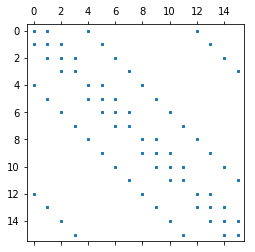

In [5]:
plt.spy(H, markersize = 2)
plt.show()

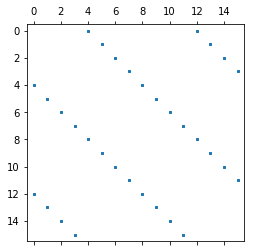

In [6]:
plt.spy(V, markersize = 2)
plt.show()

## 5. Create a random state
* In all the LSQT methods, the first crucial step is to use random vector approximation for evaluating the trace of a matrix.
* We use random phase vector, whose elements can be written as $e^{i\theta}=\cos(\theta)+i\sin(\theta)$, where $\theta$ is a random number within $[0, 2\pi]$.

### 5.1 Define the function

In [7]:
def create_state(N):
    """
    Function to construct a complex random vector
    Args:
        N (int): Length of the vector
    Returns:
        phi (complex ndarray): The random vector
    """
    random_phase = np.random.uniform(0, 2 * np.pi, N)
    phi = np.cos(random_phase) + np.sin(random_phase) * 1j; 
    phi = phi / np.linalg.norm(phi);
    return phi

### 5.2 Check the function
1. We see that the vector is complex and is correctely normalized to 1

In [24]:
phi = create_state(10)
print("phi = ")
print(phi)
print("norm(phi) = ")
print(np.linalg.norm(phi)) # should be 1

phi = 
[-0.30401535-0.08703257j -0.31124759+0.05590111j  0.21777503+0.22929028j
 -0.26750446+0.16864567j -0.08969327+0.30324102j  0.03428133+0.3143641j
  0.18015610+0.25989186j -0.31530946-0.02408203j  0.12244135+0.29156151j
 -0.04371410-0.31319176j]
norm(phi) = 
1.0
